In [1]:
pip install umap-learn


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
 # Step 1: Import libraries
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import umap
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load dataset
df = pd.read_csv("../data/cleaned_github_users.csv")

# Step 3: Preprocess 'Languages' column
df['Languages'] = df['Languages'].fillna('Unknown')
df['Language_List'] = df['Languages'].apply(lambda x: [lang.strip() for lang in x.split(",")])

mlb = MultiLabelBinarizer()
lang_encoded = mlb.fit_transform(df['Language_List'])

# Step 4: Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='jaccard', random_state=42)
embedding = reducer.fit_transform(lang_encoded)

# Step 5: Drop any NaNs from UMAP output
embedding_df = pd.DataFrame(embedding, columns=["UMAP_X", "UMAP_Y"])
embedding_df = embedding_df.dropna()

# Step 6: Re-align df with cleaned embedding (optional but recommended)
df_cleaned = df.loc[embedding_df.index].reset_index(drop=True)
embedding_df = embedding_df.reset_index(drop=True)

# Step 7: Apply DBSCAN
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.3, min_samples=5, metric='euclidean')
labels = clustering.fit_predict(embedding_df)

# Step 8: Add cluster labels
df_cleaned['UMAP_X'] = embedding_df['UMAP_X']
df_cleaned['UMAP_Y'] = embedding_df['UMAP_Y']
df_cleaned['Cluster'] = labels



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/s

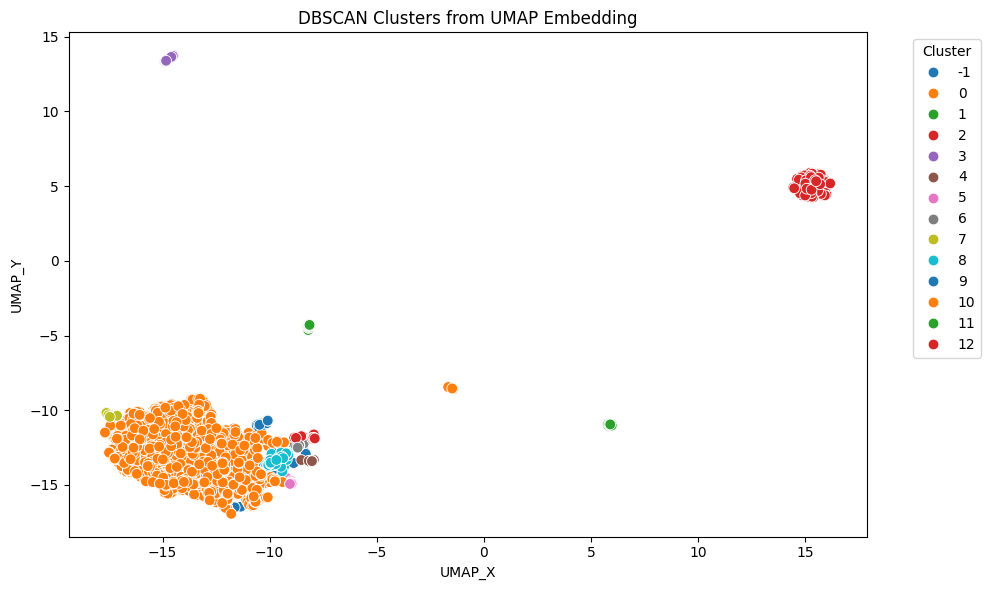

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='UMAP_X',
    y='UMAP_Y',
    hue='Cluster',
    data=df_cleaned,
    palette='tab10',
    s=60
)
plt.title("DBSCAN Clusters from UMAP Embedding")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [9]:
# Show top repositories per cluster
for cluster_id in sorted(df_cleaned['Cluster'].unique()):
    print(f"\n🔍 Cluster {cluster_id} - Top Repositories:")
    subset = df_cleaned[df_cleaned['Cluster'] == cluster_id]
    repo_list = subset['Repositories'].dropna().str.split(', ').explode()
    top_repos = repo_list.value_counts().head(5)
    print(top_repos)



🔍 Cluster -1 - Top Repositories:
Repositories
Magento-Two-factor-Authentication    1
expunge.io                           1
cucumber                             1
CS193P                               1
council_map                          1
Name: count, dtype: int64

🔍 Cluster 0 - Top Repositories:
Repositories
dotfiles    666
homebrew    144
docs        113
rails       107
bundler     105
Name: count, dtype: int64

🔍 Cluster 1 - Top Repositories:
Repositories
active_merchant    6
rails              6
authlogic          3
paperclip          3
i18n               3
Name: count, dtype: int64

🔍 Cluster 2 - Top Repositories:
Repositories
Unknown                      441
tree                           2
install-sql-server-action      2
pandas-decimal                 2
Gravityforms-es_ES             2
Name: count, dtype: int64

🔍 Cluster 3 - Top Repositories:
Repositories
attachment_fu    3
sample_app       3
demo_app         2
first_app        2
prawn            2
Name: count, dtype: int64

In [ ]:
# Define domain tags
cluster_domains = {
    0: "DevOps",
    1: "Web Dev (Ruby)",
    2: "Sparse",
    3: "Web Dev",
    4: "Misc",
    5: "Web Dev (Ruby)",
    6: "Systems",
    7: "Infrastructure",
    8: "Generalist",
    9: "Web Dev (Ruby)",
    10: "Misc",
    11: "Ripple Projects",
    12: "Game Dev"
}

# Assign domain
df_cleaned['Domain_Tag'] = df_cleaned['Cluster'].map(cluster_domains)

df_cleaned.to_csv("../data/clustered_users_with_domains.csv", index=False)



In [11]:
def recommend_with_filters(username, preferred_location=None, preferred_domain=None, top_k=5):
    if username not in hybrid_df['Username'].values:
        print("❌ Username not found.")
        return pd.DataFrame()

    recs = hybrid_df_sorted[hybrid_df_sorted['Username'] != username].copy()

    if preferred_location:
        recs = recs[recs['Location'].str.contains(preferred_location, case=False, na=False)]

    if preferred_domain:
        recs = recs[recs['Domain_Tag'] == preferred_domain]

    return recs[['Username', 'Languages', 'Location', 'Profile_URL', 'Domain_Tag', 'hybrid_score', 'explanation']].head(top_k)


/var/folders/wv/nmvg2kvx7ns_8xhm99sdtmfm0000gn/T/ipykernel_89129/3404076899.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts.index, y=domain_counts.values, palette="viridis")


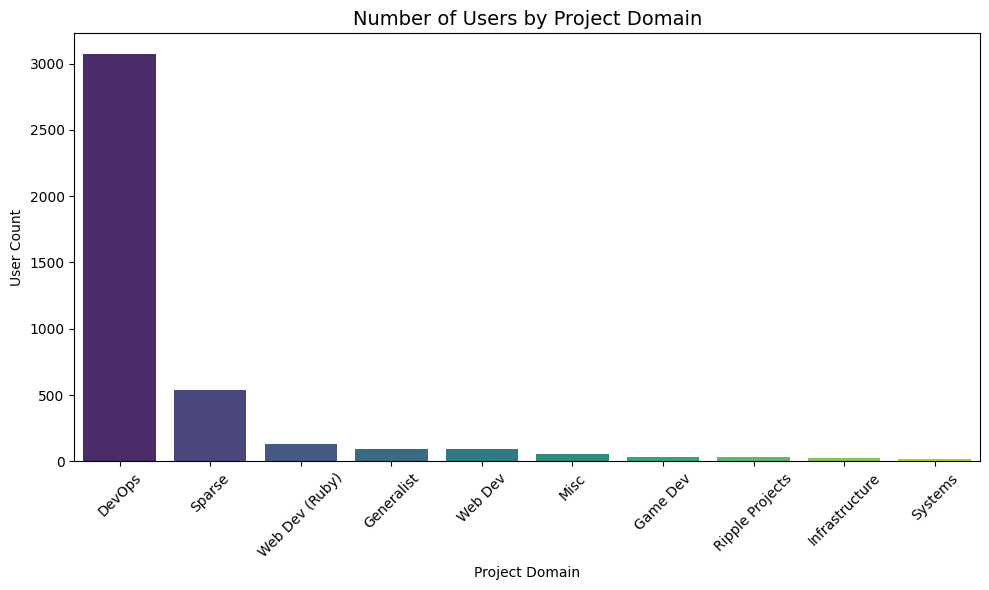

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count number of users in each domain
domain_counts = df_cleaned['Domain_Tag'].value_counts()

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=domain_counts.index, y=domain_counts.values, palette="viridis")
plt.title("Number of Users by Project Domain", fontsize=14)
plt.ylabel("User Count")
plt.xlabel("Project Domain")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


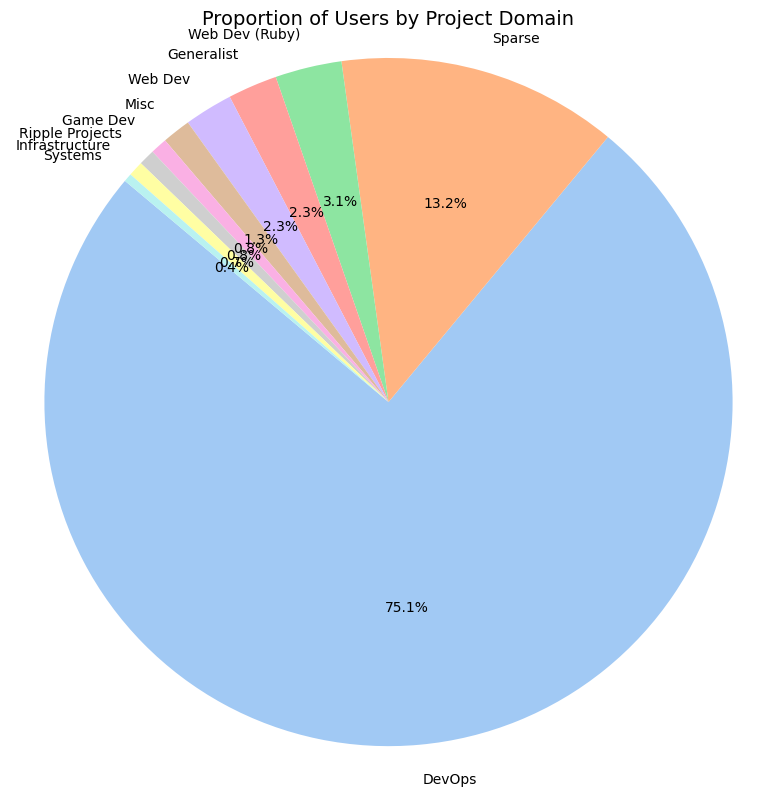

In [13]:
# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(domain_counts.values, labels=domain_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Proportion of Users by Project Domain", fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import silhouette_score
import numpy as np

# Re-create UMAP and DBSCAN properly
import umap
from sklearn.cluster import DBSCAN

# Only use the rows that went into UMAP
df_embedding_input = df_cleaned[['Followers', 'Following', 'Public_Repos']].dropna()

# UMAP projection
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = umap_model.fit_transform(df_embedding_input)

# DBSCAN clustering
clustering = DBSCAN(eps=0.3, min_samples=5)
labels = clustering.fit_predict(embedding)

# Now filter valid points (if UMAP or DBSCAN produced NaNs)
valid_indices = ~np.isnan(embedding).any(axis=1)
X_valid = embedding[valid_indices]
labels_valid = np.array(labels)[valid_indices]

# Calculate silhouette score
score = silhouette_score(X_valid, labels_valid)
print(f"✅ Silhouette Score: {score:.2f}")



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Silhouette Score: 0.15


/var/folders/wv/nmvg2kvx7ns_8xhm99sdtmfm0000gn/T/ipykernel_89129/3756227004.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


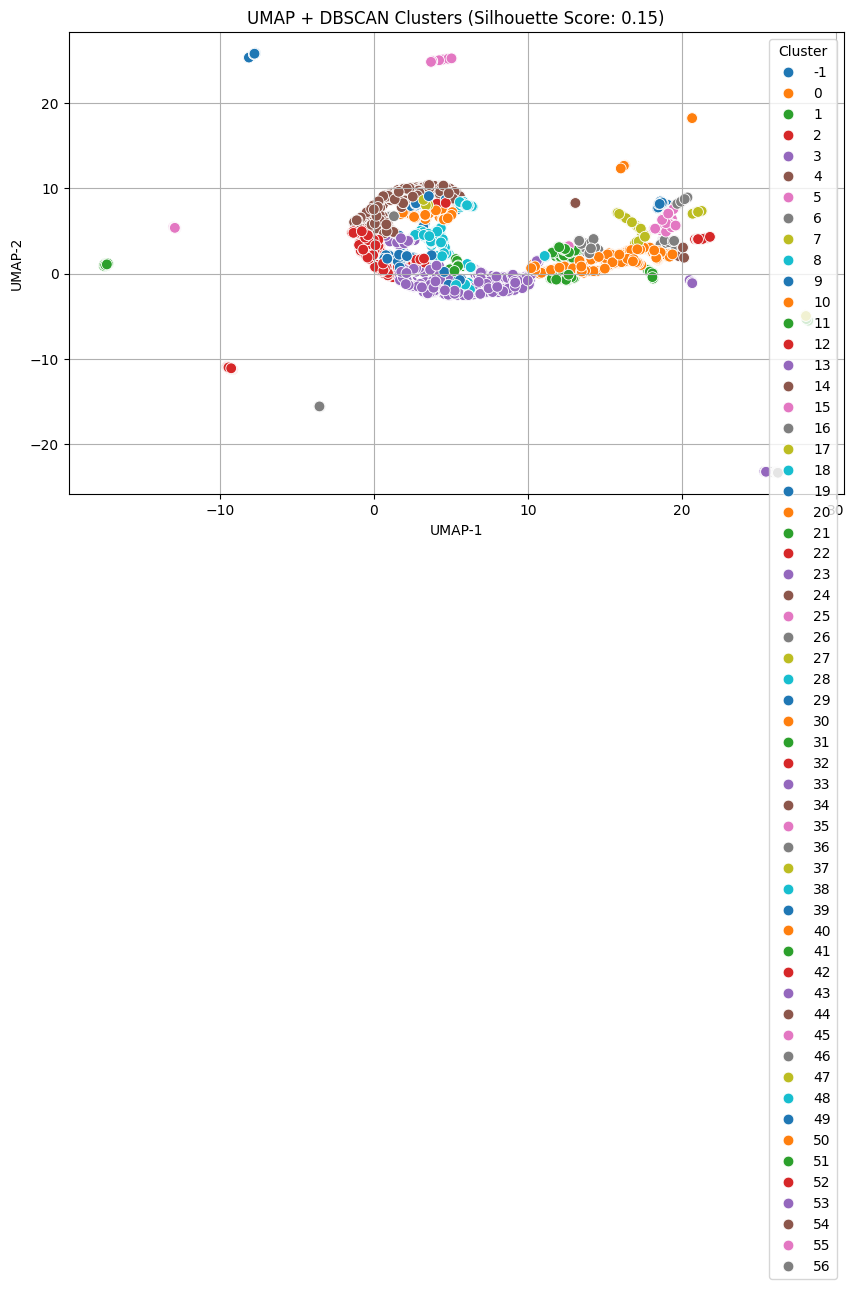

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_valid[:, 0], y=X_valid[:, 1],
    hue=labels_valid, palette="tab10", legend='full', s=60
)
plt.title(f"UMAP + DBSCAN Clusters (Silhouette Score: {score:.2f})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()